# Projeto final - diagnostico de cancer

# Colocar referencia do codigo base

In [1]:
import SimpleITK as sitk
import numpy as np
import csv
from glob import glob
import pandas as pd

%matplotlib notebook

In [2]:
input_path = "sets/"
output_path = "outs/"

file_list=glob(input_path+"*.mhd")

In [3]:
# Helper function to get rows in data frame associated 
# with each file
def get_filename(case):
    global file_list
    for f in file_list:
        if case in f:
            return(f)

In [4]:
def make_mask(center,diam,z,width,height,spacing,origin):
    '''
Center : centers of circles px -- list of coordinates x,y,z
diam : diameters of circles px -- diameter
widthXheight : pixel dim of image
spacing = mm/px conversion rate np array x,y,z
origin = x,y,z mm np.array
z = z position of slice in world coordinates mm
    '''
    mask = np.zeros([height,width]) # 0's everywhere except nodule swapping x,y to match img
    #convert to nodule space from world coordinates

    # Defining the voxel range in which the nodule falls
    v_center = (center-origin)/spacing
    v_diam = int(diam/spacing[0]+5)
    v_xmin = np.max([0,int(v_center[0]-v_diam)-5])
    v_xmax = np.min([width-1,int(v_center[0]+v_diam)+5])
    v_ymin = np.max([0,int(v_center[1]-v_diam)-5]) 
    v_ymax = np.min([height-1,int(v_center[1]+v_diam)+5])

    v_xrange = range(v_xmin,v_xmax+1)
    v_yrange = range(v_ymin,v_ymax+1)

    # Convert back to world coordinates for distance calculation
    x_data = [x*spacing[0]+origin[0] for x in range(width)]
    y_data = [x*spacing[1]+origin[1] for x in range(height)]

    # Fill in 1 within sphere around nodule
    for v_x in v_xrange:
        for v_y in v_yrange:
            p_x = spacing[0]*v_x + origin[0]
            p_y = spacing[1]*v_y + origin[1]
            if np.linalg.norm(center-np.array([p_x,p_y,z]))<=diam:
                mask[int((p_y-origin[1])/spacing[1]),int((p_x-origin[0])/spacing[0])] = 1.0
    return(mask)

In [5]:
def matrix2int16(matrix):
    ''' 
matrix must be a numpy array NXN
Returns uint16 version
    '''
    m_min= np.min(matrix)
    m_max= np.max(matrix)
    #matrix = matrix-m_min  # Isto e um bug no codigo original.
    return(np.array(np.rint( (matrix-m_min)/float(m_max-m_min) * 65535.0),dtype=np.uint16))

In [6]:
# The locations of the nodes
df_node = pd.read_csv("annotations.csv")
df_node["file"] = df_node["seriesuid"].apply(get_filename)

print(df_node.head(10))

df_node = df_node.dropna()

# Looping over the image files
fcount = 0

fcount = 0
for img_file in file_list:
    print ("Getting mask for image file %s" % img_file.replace(input_path,""))
    mini_df = df_node[df_node["file"]==img_file] #constroi um mini-df com infos de nodulos pra cada file
    if len(mini_df)>0:    # pulas as slices sem nodulos 
        biggest_node = np.argsort(mini_df["diameter_mm"].values)[-1]   # pega dados do maior nodulo
        node_x = mini_df["coordX"].values[biggest_node]
        node_y = mini_df["coordY"].values[biggest_node]
        node_z = mini_df["coordZ"].values[biggest_node]
        diam = mini_df["diameter_mm"].values[biggest_node]
        #
        # extracting image
        #
        itk_img = sitk.ReadImage(img_file) #pega imagem
        img_array = sitk.GetArrayFromImage(itk_img) #indexes are z,y,x --pega dados da imagem
        num_z,height,width = img_array.shape        #heightXwidth constitute the transverse plane
        imgs = np.ndarray([3,height,width],dtype=np.uint16)
        masks = np.ndarray([3,height,width],dtype=np.uint8)
        center = np.array([node_x,node_y,node_z])  #centro do nodulo
        origin = np.array(itk_img.GetOrigin()) #x,y,z  Origin in world coordinates (mm)
        spacing = np.array(itk_img.GetSpacing())# spacing of voxels in world coor. (mm) --transforma dimensao da img em mm
        v_center =np.rint((center-origin)/spacing)  # nodule center in voxel space --encaixa local do nodulo na img
        #
        # for each slice in the image, convert the image data to the uint16 range
        # and generate a binary mask for the nodule location
        #
        i = 0
        for i_z in range(int(v_center[2])-1,int(v_center[2])+2):
            mask = make_mask(center,diam,i_z*spacing[2]+origin[2],width,height,spacing,origin)
            masks[i] = mask
            imgs[i] = matrix2int16(img_array[i_z])
            i+=1
        #

        np.save(output_path+"images_%d.npy" % (fcount) ,imgs)
        np.save(output_path+"masks_%d.npy" % (fcount) ,masks)
        fcount+=1

                                           seriesuid      coordX      coordY  \
0  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222... -128.699421 -175.319272   
1  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...  103.783651 -211.925149   
2  1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793...   69.639017 -140.944586   
3  1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...  -24.013824  192.102405   
4  1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...    2.441547  172.464881   
5  1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...   90.931713  149.027266   
6  1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...   89.540769  196.405159   
7  1.3.6.1.4.1.14519.5.2.1.6279.6001.100953483028...   81.509646   54.957219   
8  1.3.6.1.4.1.14519.5.2.1.6279.6001.102681962408...  105.055792   19.825260   
9  1.3.6.1.4.1.14519.5.2.1.6279.6001.104562737760... -124.834262  127.247155   

       coordZ  diameter_mm                                               file  
0 -298.387506     5.651471             

Getting mask for image file sets\1.3.6.1.4.1.14519.5.2.1.6279.6001.144438612068946916340281098509.mhd
Getting mask for image file sets\1.3.6.1.4.1.14519.5.2.1.6279.6001.144883090372691745980459537053.mhd
Getting mask for image file sets\1.3.6.1.4.1.14519.5.2.1.6279.6001.144943344795414353192059796098.mhd
Getting mask for image file sets\1.3.6.1.4.1.14519.5.2.1.6279.6001.145283812746259413053188838096.mhd
Getting mask for image file sets\1.3.6.1.4.1.14519.5.2.1.6279.6001.145474881373882284343459153872.mhd
Getting mask for image file sets\1.3.6.1.4.1.14519.5.2.1.6279.6001.145759169833745025756371695397.mhd
Getting mask for image file sets\1.3.6.1.4.1.14519.5.2.1.6279.6001.146429221666426688999739595820.mhd
Getting mask for image file sets\1.3.6.1.4.1.14519.5.2.1.6279.6001.146603910507557786636779705509.mhd
Getting mask for image file sets\1.3.6.1.4.1.14519.5.2.1.6279.6001.146987333806092287055399155268.mhd
Getting mask for image file sets\1.3.6.1.4.1.14519.5.2.1.6279.6001.147250707071097

Getting mask for image file sets\1.3.6.1.4.1.14519.5.2.1.6279.6001.199220738144407033276946096708.mhd
Getting mask for image file sets\1.3.6.1.4.1.14519.5.2.1.6279.6001.199670099218798685977406484591.mhd
Getting mask for image file sets\1.3.6.1.4.1.14519.5.2.1.6279.6001.199975006921901879512837687266.mhd
Getting mask for image file sets\1.3.6.1.4.1.14519.5.2.1.6279.6001.200558451375970945040979397866.mhd
Getting mask for image file sets\1.3.6.1.4.1.14519.5.2.1.6279.6001.200837896655745926888305239398.mhd
Getting mask for image file sets\1.3.6.1.4.1.14519.5.2.1.6279.6001.202187810895588720702176009630.mhd
Getting mask for image file sets\1.3.6.1.4.1.14519.5.2.1.6279.6001.202464973819273687476049035824.mhd
Getting mask for image file sets\1.3.6.1.4.1.14519.5.2.1.6279.6001.202476538079060560282495099956.mhd
Getting mask for image file sets\1.3.6.1.4.1.14519.5.2.1.6279.6001.202643836890896697853521610450.mhd
Getting mask for image file sets\1.3.6.1.4.1.14519.5.2.1.6279.6001.202811684116768

Getting mask for image file sets\1.3.6.1.4.1.14519.5.2.1.6279.6001.252697338970999211181671881792.mhd
Getting mask for image file sets\1.3.6.1.4.1.14519.5.2.1.6279.6001.253283426904813468115158375647.mhd
Getting mask for image file sets\1.3.6.1.4.1.14519.5.2.1.6279.6001.253322967203074795232627653819.mhd
Getting mask for image file sets\1.3.6.1.4.1.14519.5.2.1.6279.6001.254254303842550572473665729969.mhd


C:\Users\lucas\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in short_scalars
  if __name__ == '__main__':


Getting mask for image file sets\1.3.6.1.4.1.14519.5.2.1.6279.6001.259018373683540453277752706262.mhd
Getting mask for image file sets\1.3.6.1.4.1.14519.5.2.1.6279.6001.259123825760999546551970425757.mhd
Getting mask for image file sets\1.3.6.1.4.1.14519.5.2.1.6279.6001.259227883564429312164962953756.mhd
Getting mask for image file sets\1.3.6.1.4.1.14519.5.2.1.6279.6001.259543921154154401875872845498.mhd
Getting mask for image file sets\1.3.6.1.4.1.14519.5.2.1.6279.6001.261678072503577216586082745513.mhd
Getting mask for image file sets\1.3.6.1.4.1.14519.5.2.1.6279.6001.264090899378396711987322794314.mhd
Getting mask for image file sets\1.3.6.1.4.1.14519.5.2.1.6279.6001.265133389948279331857097127422.mhd
Getting mask for image file sets\1.3.6.1.4.1.14519.5.2.1.6279.6001.265453131727473342790950829556.mhd
Getting mask for image file sets\1.3.6.1.4.1.14519.5.2.1.6279.6001.265775376735520890308424143898.mhd
Getting mask for image file sets\1.3.6.1.4.1.14519.5.2.1.6279.6001.265960756233787

Getting mask for image file sets\1.3.6.1.4.1.14519.5.2.1.6279.6001.319009811633846643966578282371.mhd
Getting mask for image file sets\1.3.6.1.4.1.14519.5.2.1.6279.6001.319066480138812986026181758474.mhd
Getting mask for image file sets\1.3.6.1.4.1.14519.5.2.1.6279.6001.320111824803959660037459294083.mhd
Getting mask for image file sets\1.3.6.1.4.1.14519.5.2.1.6279.6001.320967206808467952819309001585.mhd
Getting mask for image file sets\1.3.6.1.4.1.14519.5.2.1.6279.6001.321465552859463184018938648244.mhd
Getting mask for image file sets\1.3.6.1.4.1.14519.5.2.1.6279.6001.323302986710576400812869264321.mhd
Getting mask for image file sets\1.3.6.1.4.1.14519.5.2.1.6279.6001.323541312620128092852212458228.mhd
Getting mask for image file sets\1.3.6.1.4.1.14519.5.2.1.6279.6001.323753921818102744511069914832.mhd
Getting mask for image file sets\1.3.6.1.4.1.14519.5.2.1.6279.6001.323859712968543712594665815359.mhd
Getting mask for image file sets\1.3.6.1.4.1.14519.5.2.1.6279.6001.324290109423920

Getting mask for image file sets\1.3.6.1.4.1.14519.5.2.1.6279.6001.690929968028676628605553365896.mhd
Getting mask for image file sets\1.3.6.1.4.1.14519.5.2.1.6279.6001.692598144815688523679745963696.mhd
Getting mask for image file sets\1.3.6.1.4.1.14519.5.2.1.6279.6001.707218743153927597786179232739.mhd
Getting mask for image file sets\1.3.6.1.4.1.14519.5.2.1.6279.6001.710845873679853791427022019413.mhd
Getting mask for image file sets\1.3.6.1.4.1.14519.5.2.1.6279.6001.716498695101447665580610403574.mhd
Getting mask for image file sets\1.3.6.1.4.1.14519.5.2.1.6279.6001.724251104254976962355686318345.mhd
Getting mask for image file sets\1.3.6.1.4.1.14519.5.2.1.6279.6001.741709061958490690246385302477.mhd
Getting mask for image file sets\1.3.6.1.4.1.14519.5.2.1.6279.6001.743969234977916254223533321294.mhd
Getting mask for image file sets\1.3.6.1.4.1.14519.5.2.1.6279.6001.752756872840730509471096155114.mhd
Getting mask for image file sets\1.3.6.1.4.1.14519.5.2.1.6279.6001.756684168227383

image 0


<IPython.core.display.Javascript object>


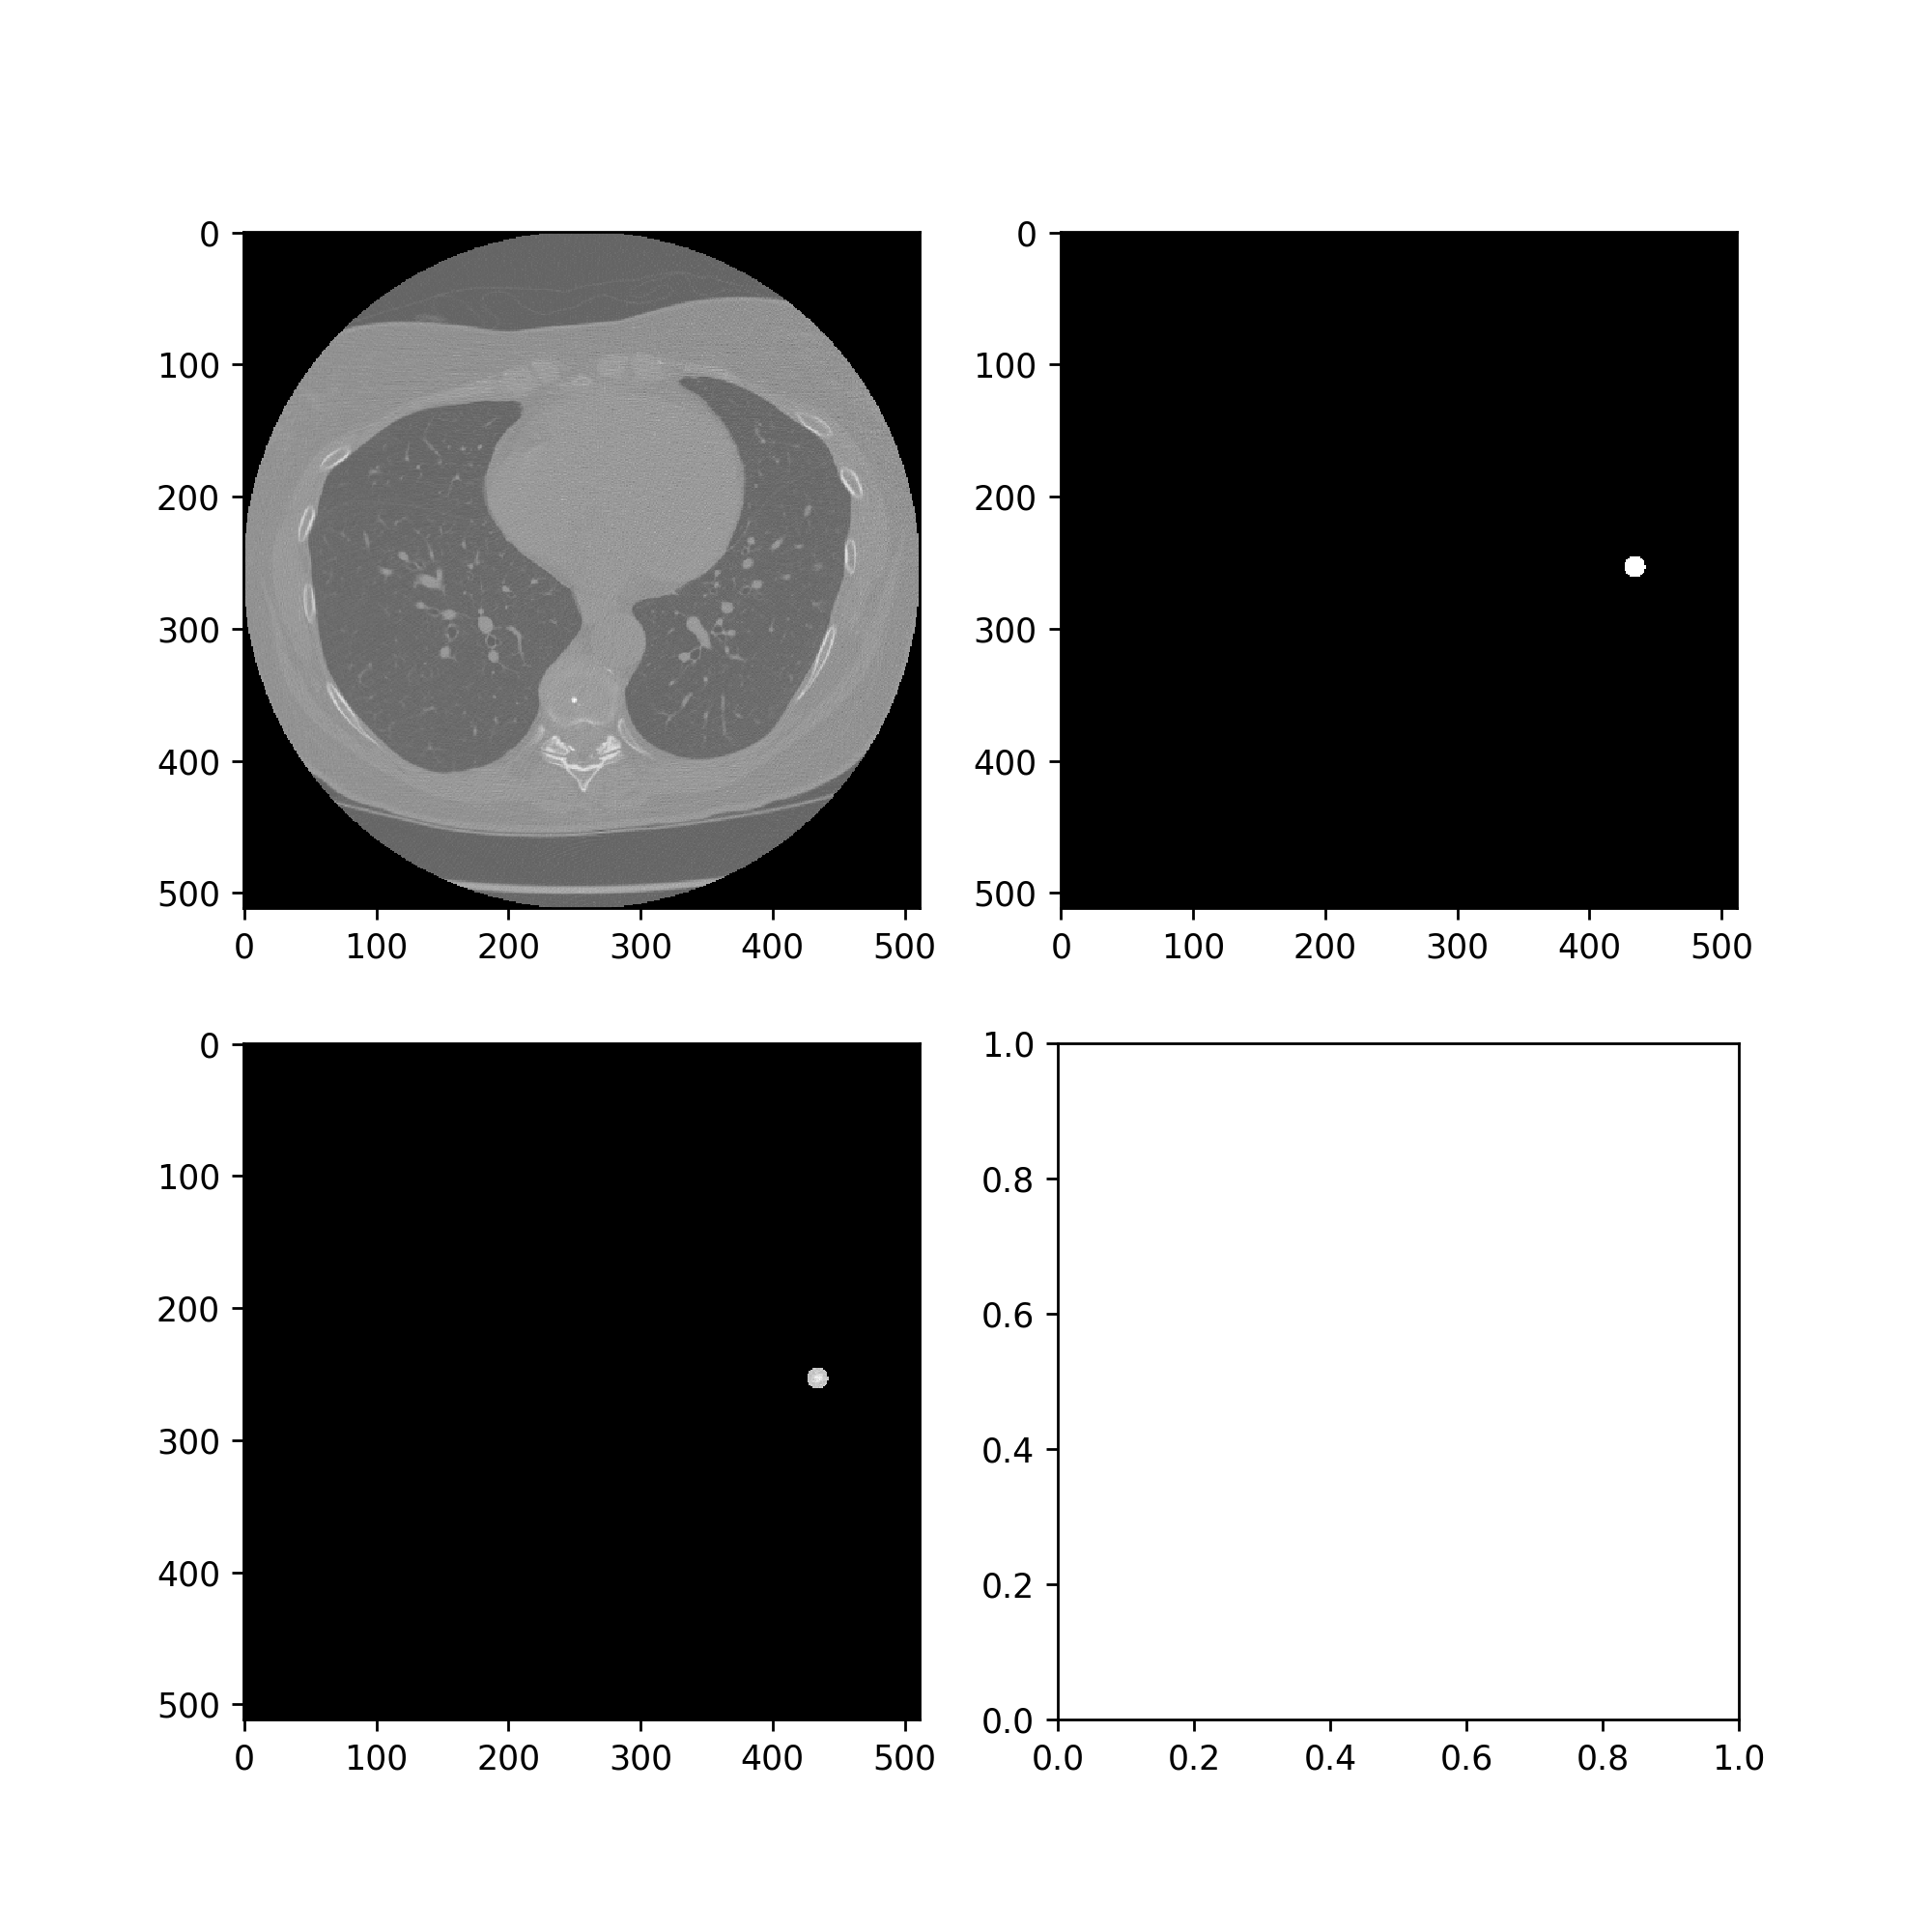

image 1


<IPython.core.display.Javascript object>


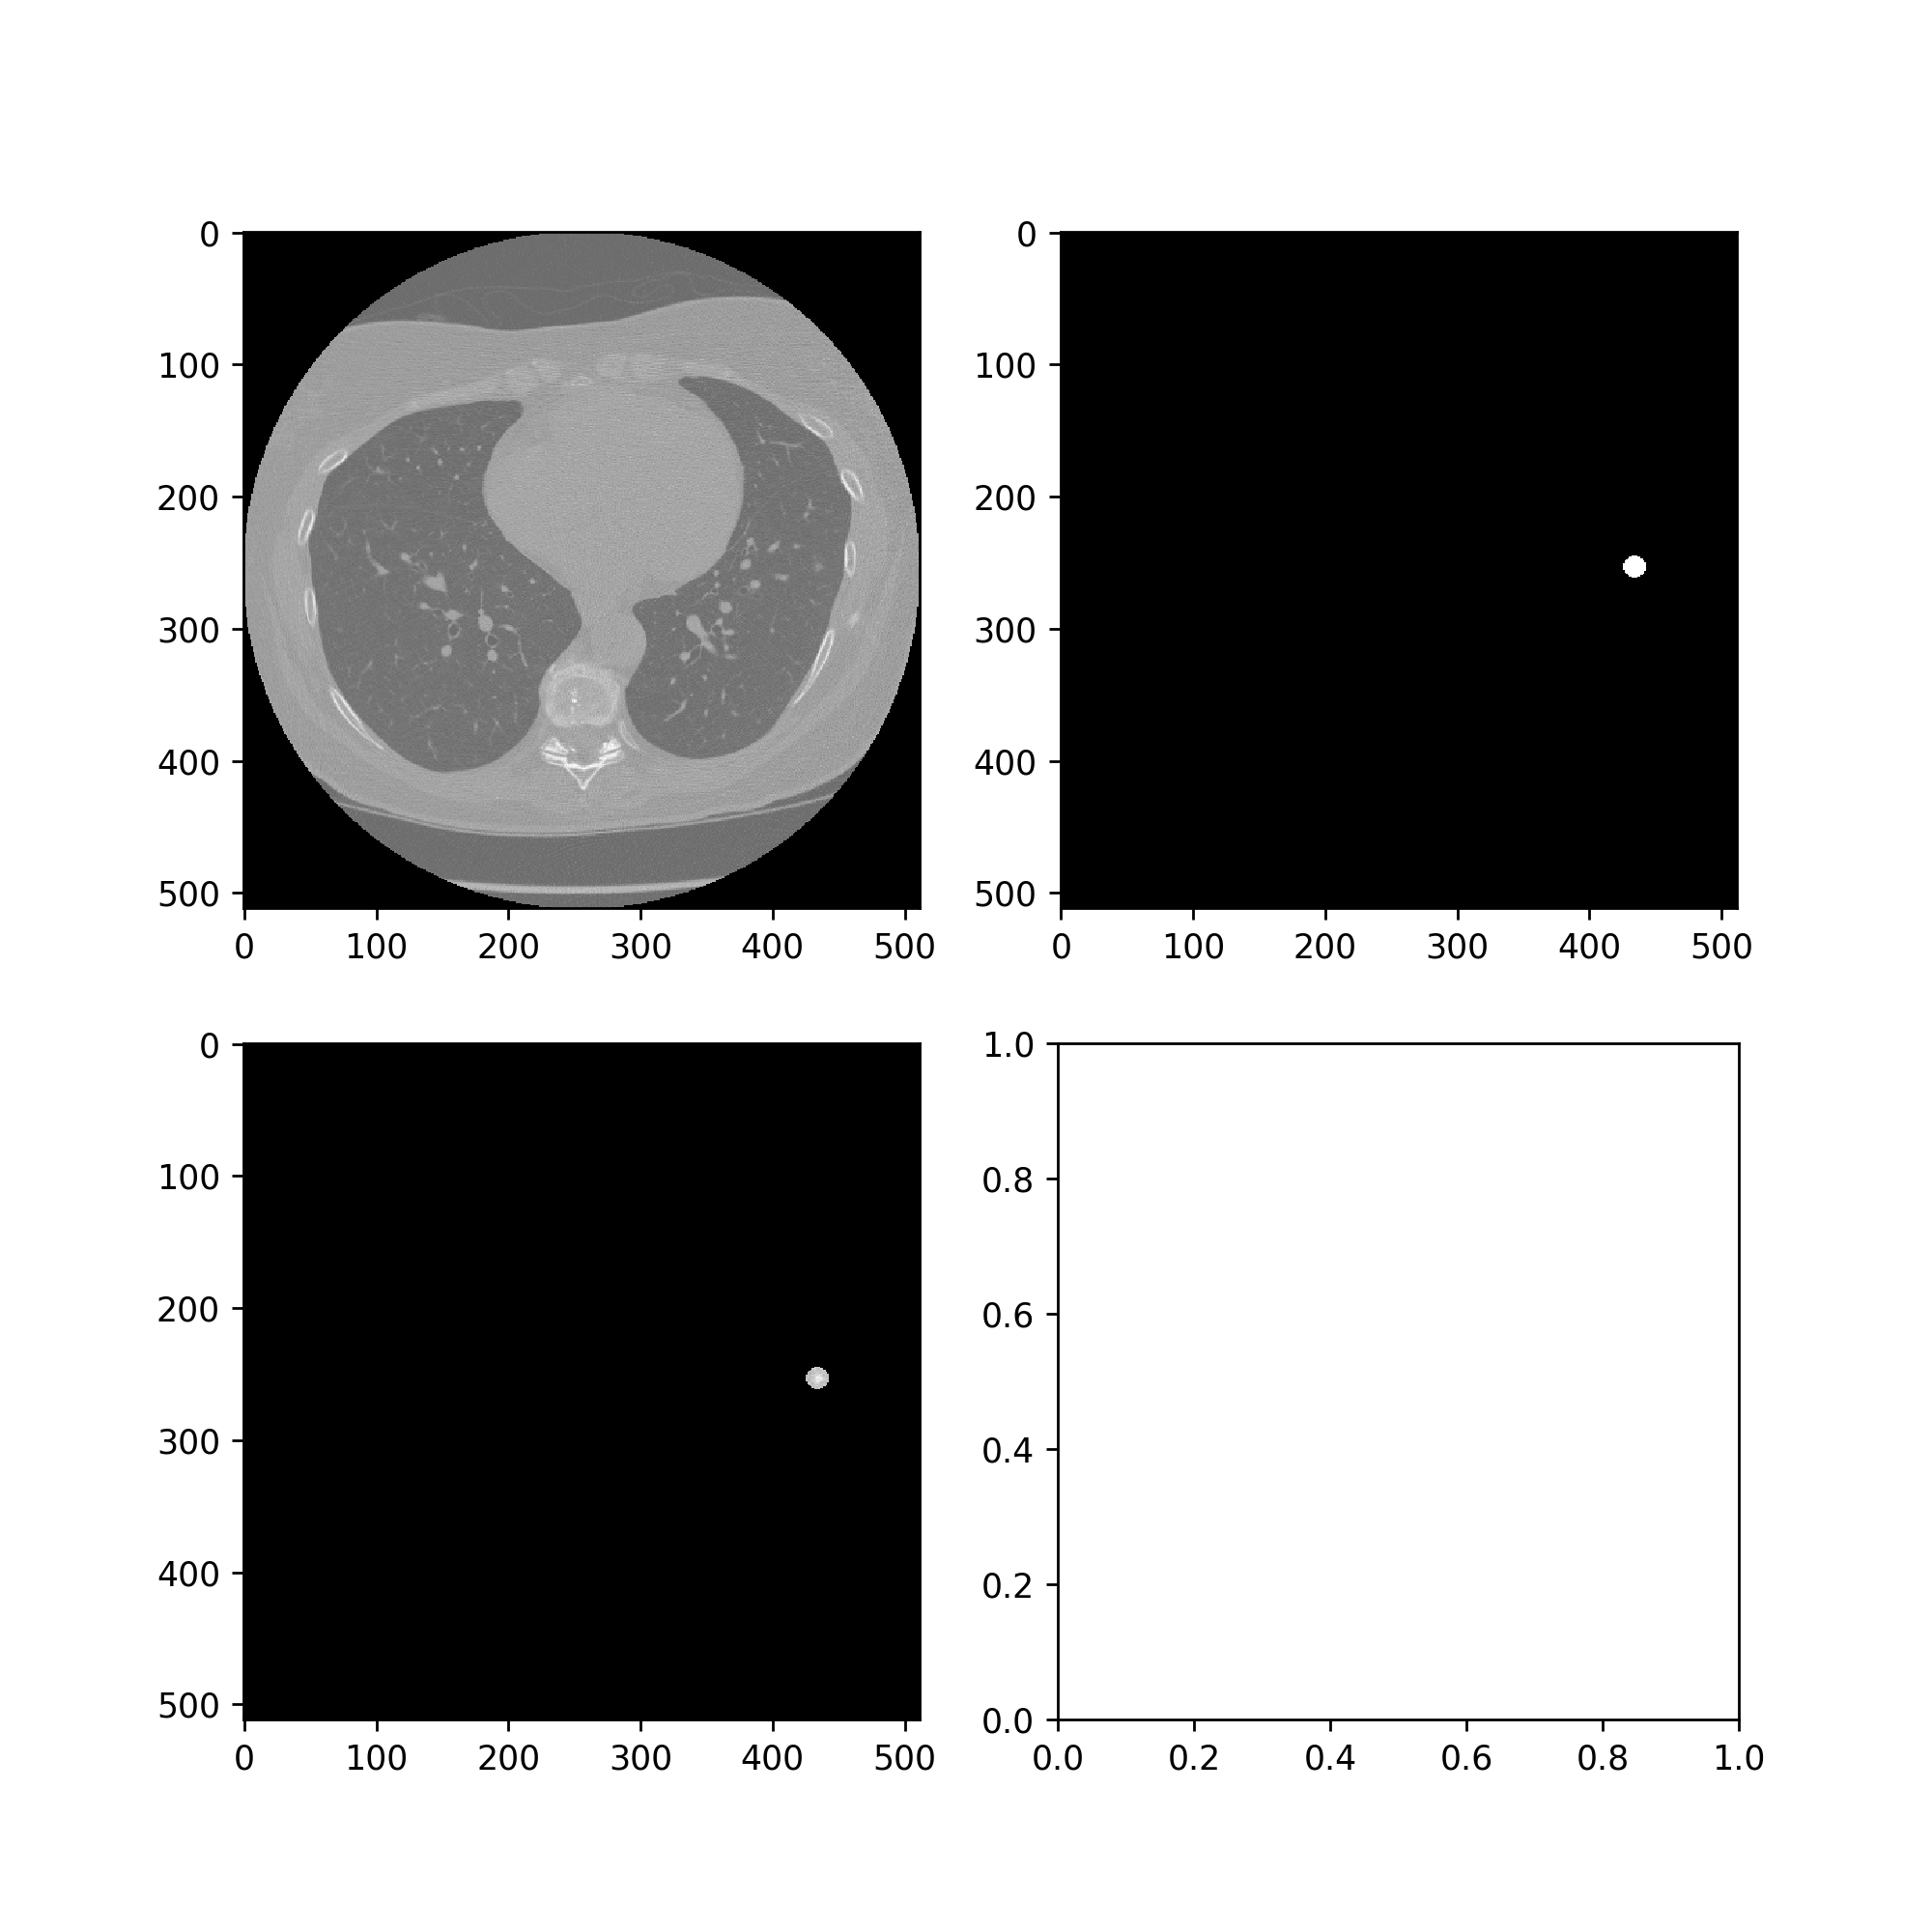

image 2


<IPython.core.display.Javascript object>


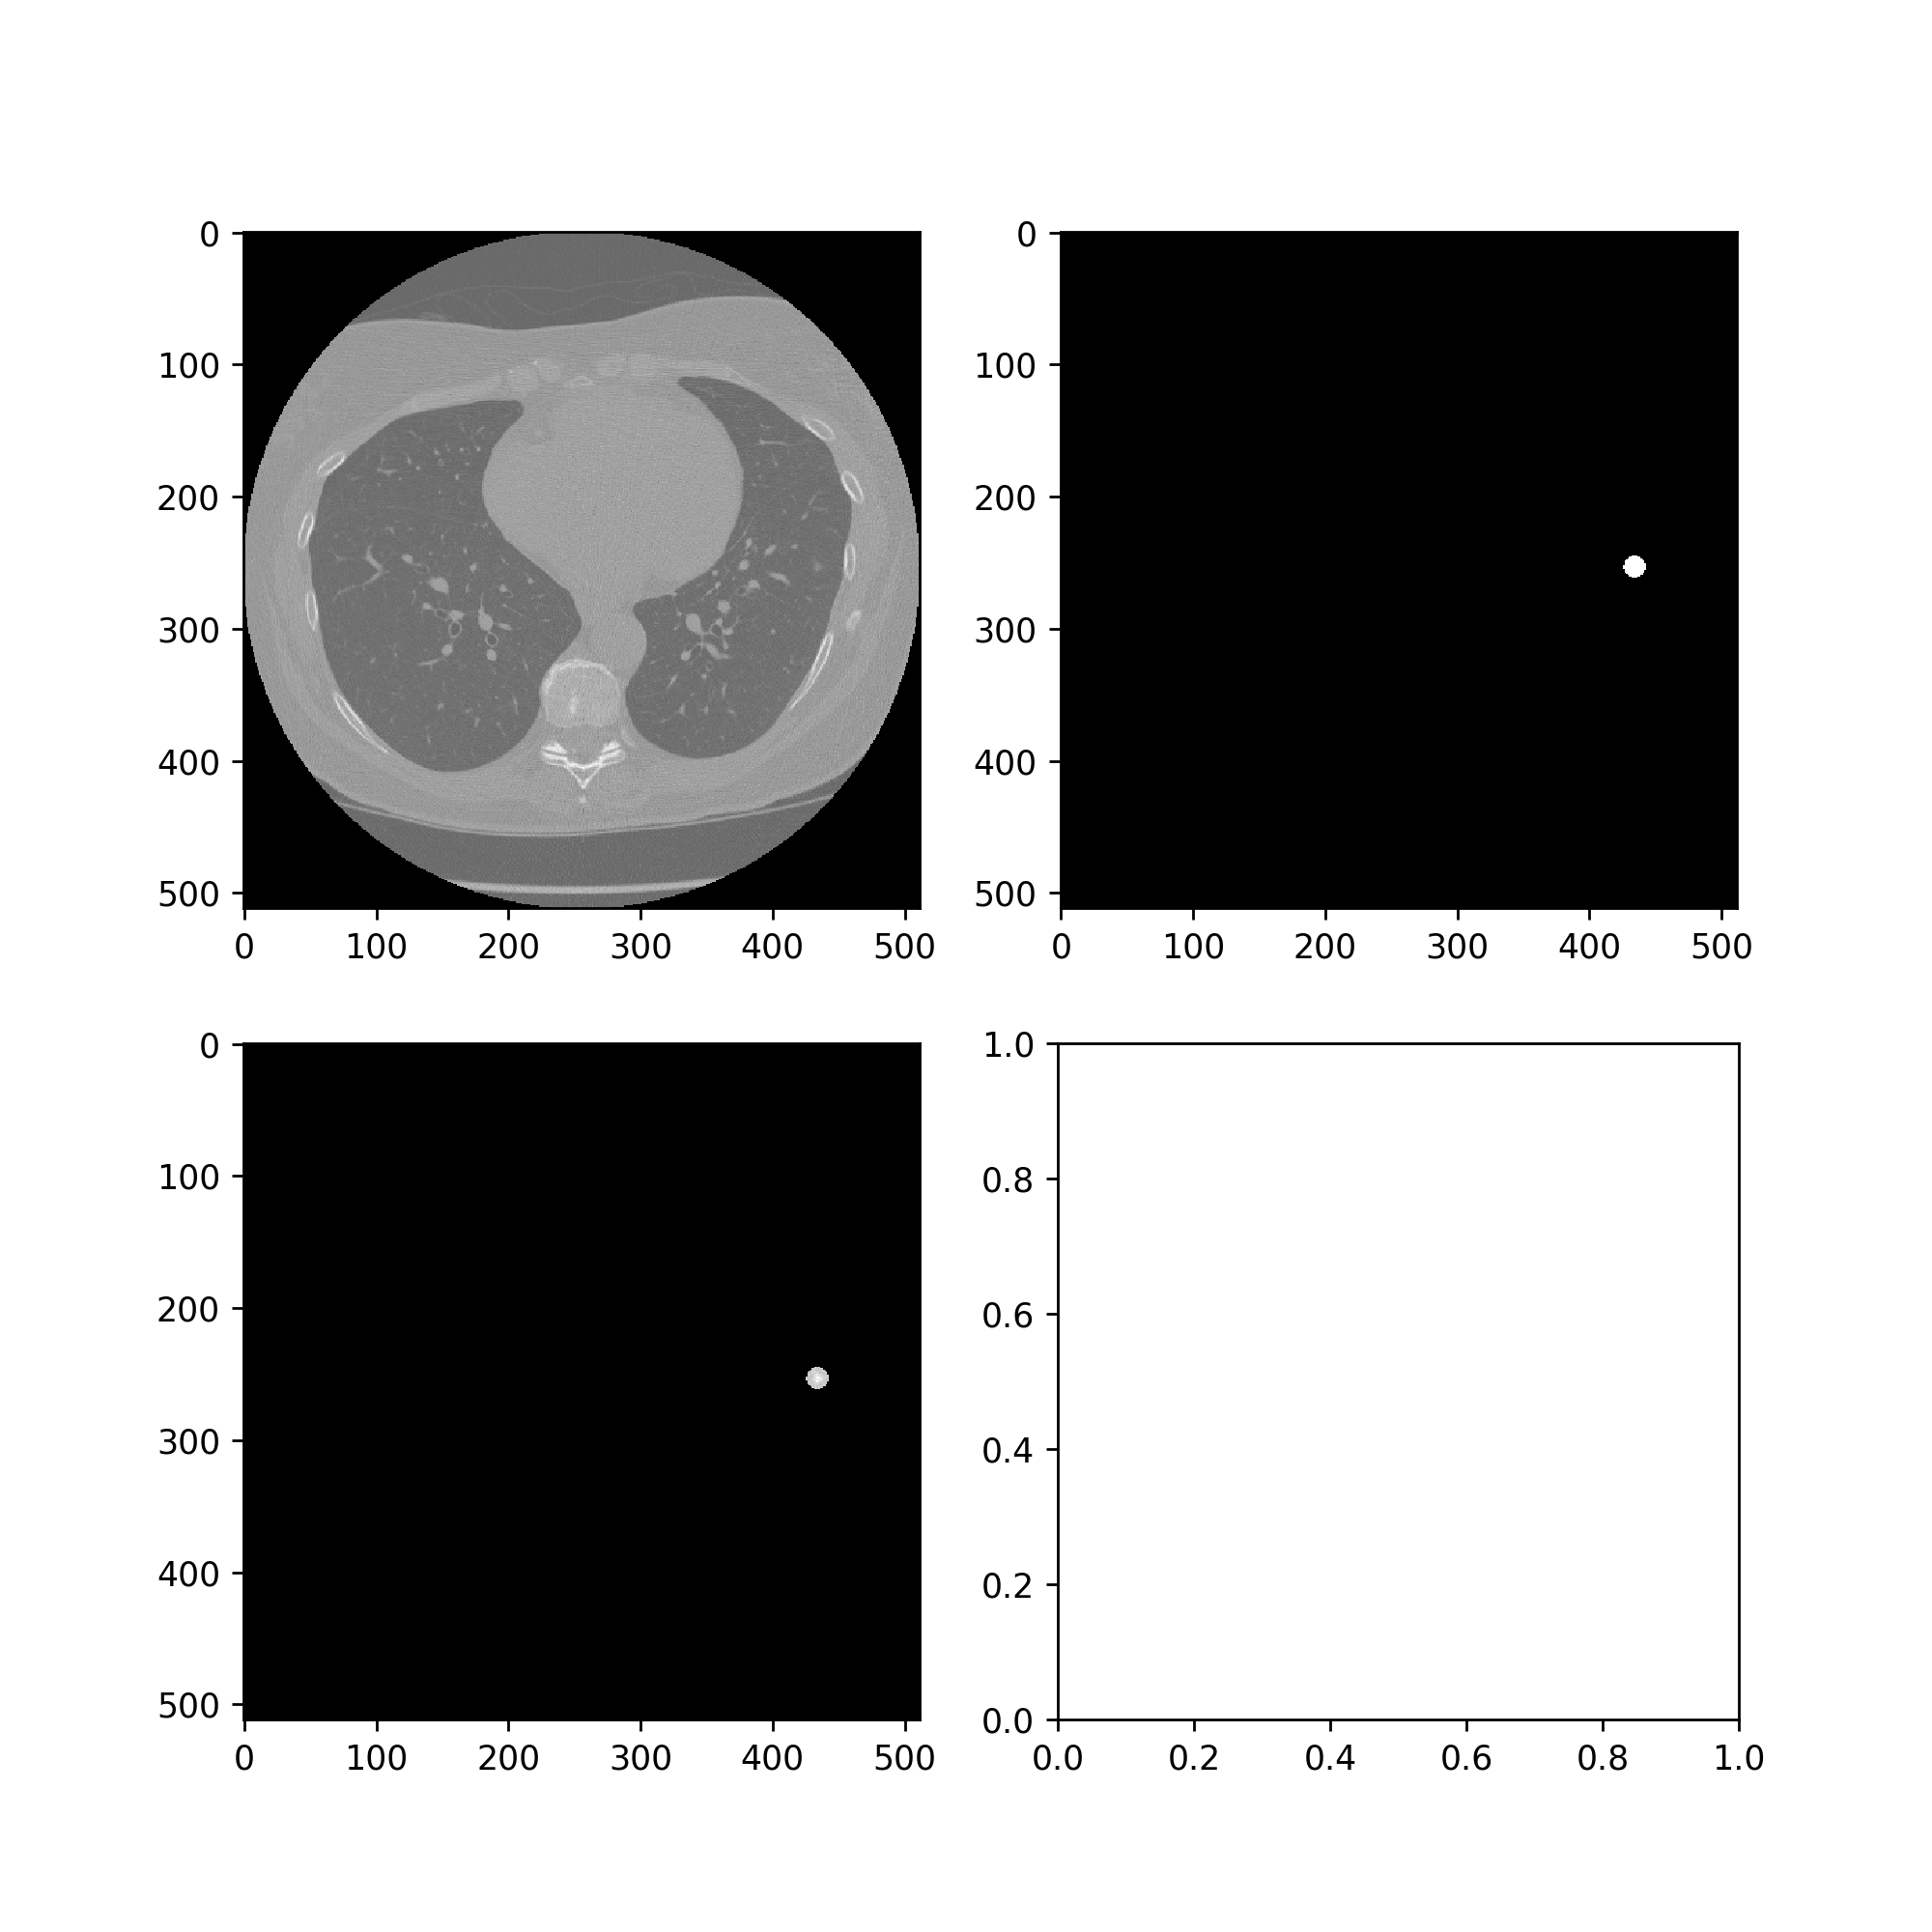

In [12]:
import matplotlib.pyplot as plt
#img_num = 0
img_num = 23
img_filename = 'outs/images_{}.npy'.format(img_num)
mask_filename = 'outs/masks_{}.npy'.format(img_num)
imgs = np.load(img_filename)
masks = np.load(mask_filename)
for i in range(len(imgs)):
    print ("image %d" % i)
    fig,ax = plt.subplots(2,2,figsize=[8,8])
    ax[0,0].imshow(imgs[i],cmap='gray') #slice tomografia
    ax[0,1].imshow(masks[i],cmap='gray') #mascara nodulo annotations.csv correspondente
    ax[1,0].imshow(imgs[i]*masks[i],cmap='gray') #mascara aplicada na slice
    plt.show()

In [8]:
from skimage import morphology
from skimage import measure
from sklearn.cluster import KMeans
from skimage.transform import resize
import matplotlib.pyplot as plt

on image outs/images_23.npy


<IPython.core.display.Javascript object>


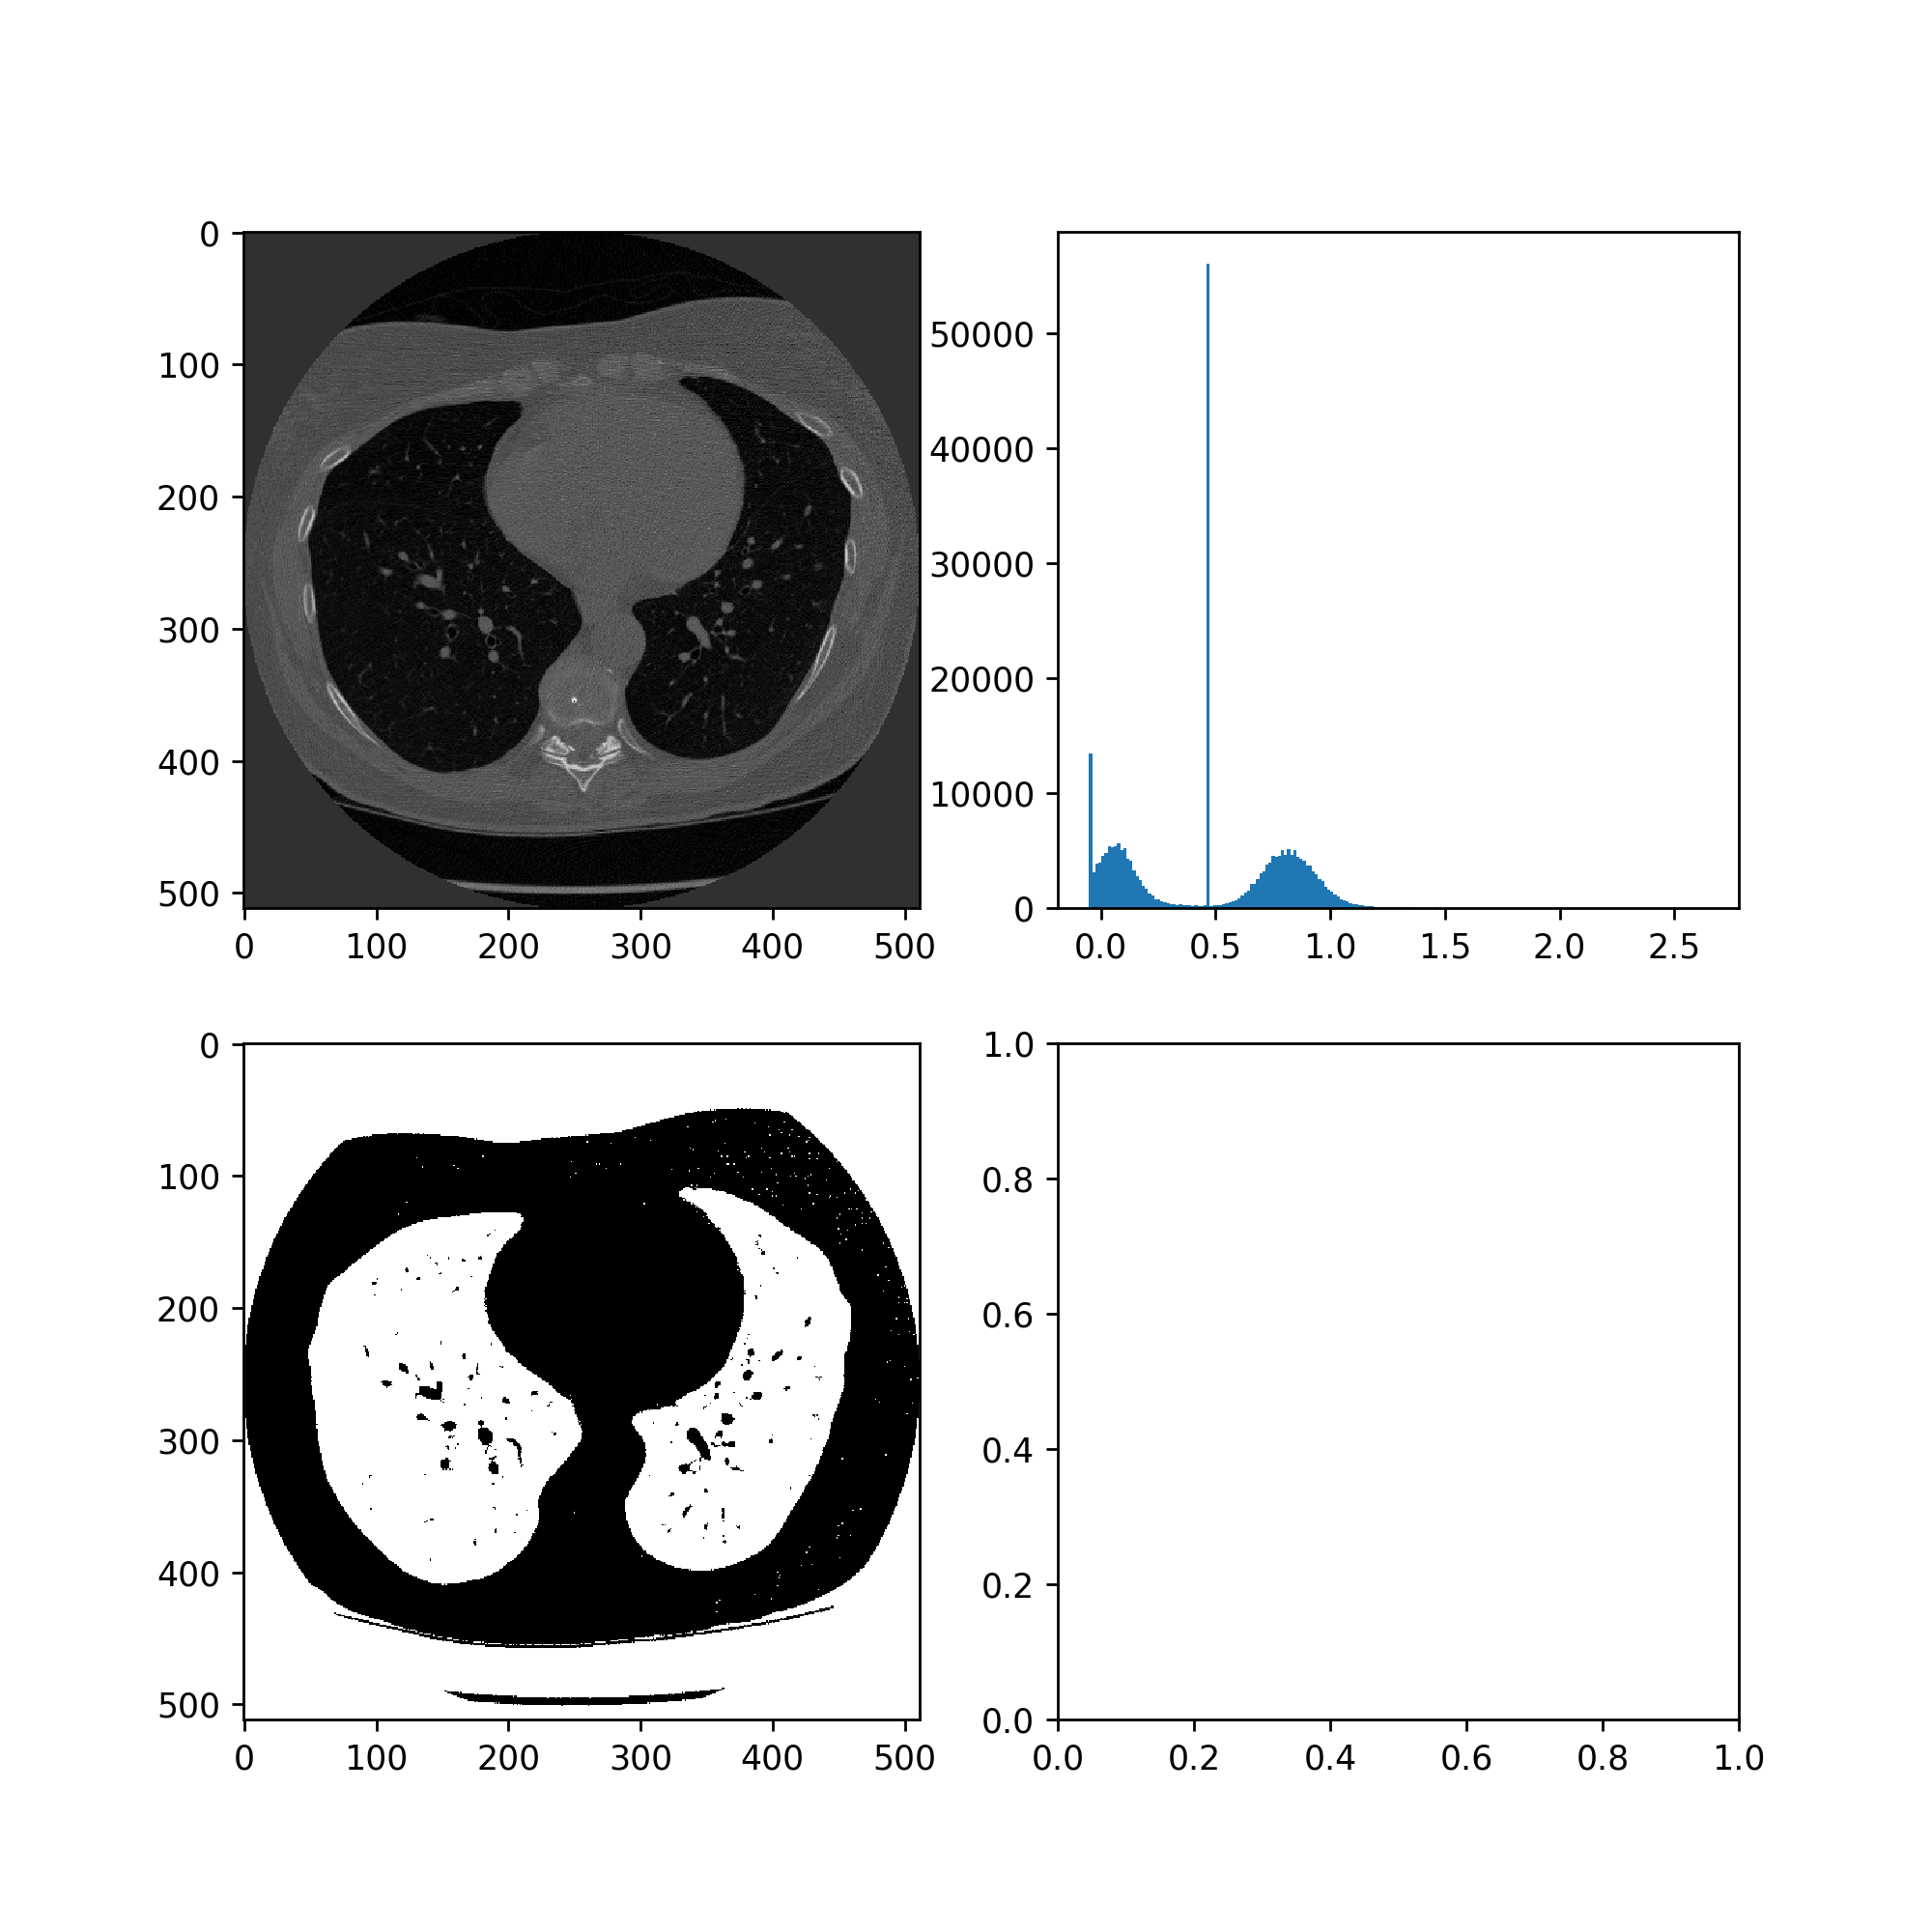

In [9]:
file_list=glob(output_path+"images_23.npy")

for img_file in file_list:
    # I ran into an error when using Kmean on np.float16, so I'm using np.float64 here
    imgs_to_process = np.load(img_file).astype(np.float64) 
    print ("on image", img_file)
    for i in range(len(imgs_to_process)):
        img = imgs_to_process[i]
        #Standardize the pixel values
        mean = np.mean(img)
        std = np.std(img)
        img = img-mean
        img = img/std

        # Find the average pixel value near the lungs
        # to renormalize washed out images
        middle = img[100:400,100:400] 
        mean = np.mean(middle)  
        max = np.max(img)
        min = np.min(img)
        # To improve threshold finding, I'm moving the 
        # underflow and overflow on the pixel spectrum
        img[img==max]=mean
        img[img==min]=mean

        #plt.hist(img.flatten(),bins=200)
        

        # Using Kmeans to separate foreground (radio-opaque tissue)
        # and background (radio transparent tissue ie lungs)
        # Doing this only on the center of the image to avoid 
        # the non-tissue parts of the image as much as possible
        #
        valid_values = np.reshape(middle,[np.prod(middle.shape),1])
        kmeans = KMeans(n_clusters=2).fit(valid_values)
        centers = sorted(kmeans.cluster_centers_.flatten())
        threshold = np.mean(centers)
        thresh_img = np.where(img<threshold,1.0,0.0)  # threshold the image
        
        fig,ax = plt.subplots(2,2,figsize=[8,8])
        ax[0,0].imshow(img,cmap='gray') #imagem normalizada
        ax[0,1].hist(img.flatten(),bins=200) # histogramas dos pixels normalizados com max  e  min tratados
        ax[1,0].imshow(thresh_img, cmap='gray') #imagem pos separacao de  threshold
        break
        
    break

outs/images_23.npy
on image outs/images_23.npy
0.4822045434013812


<IPython.core.display.Javascript object>


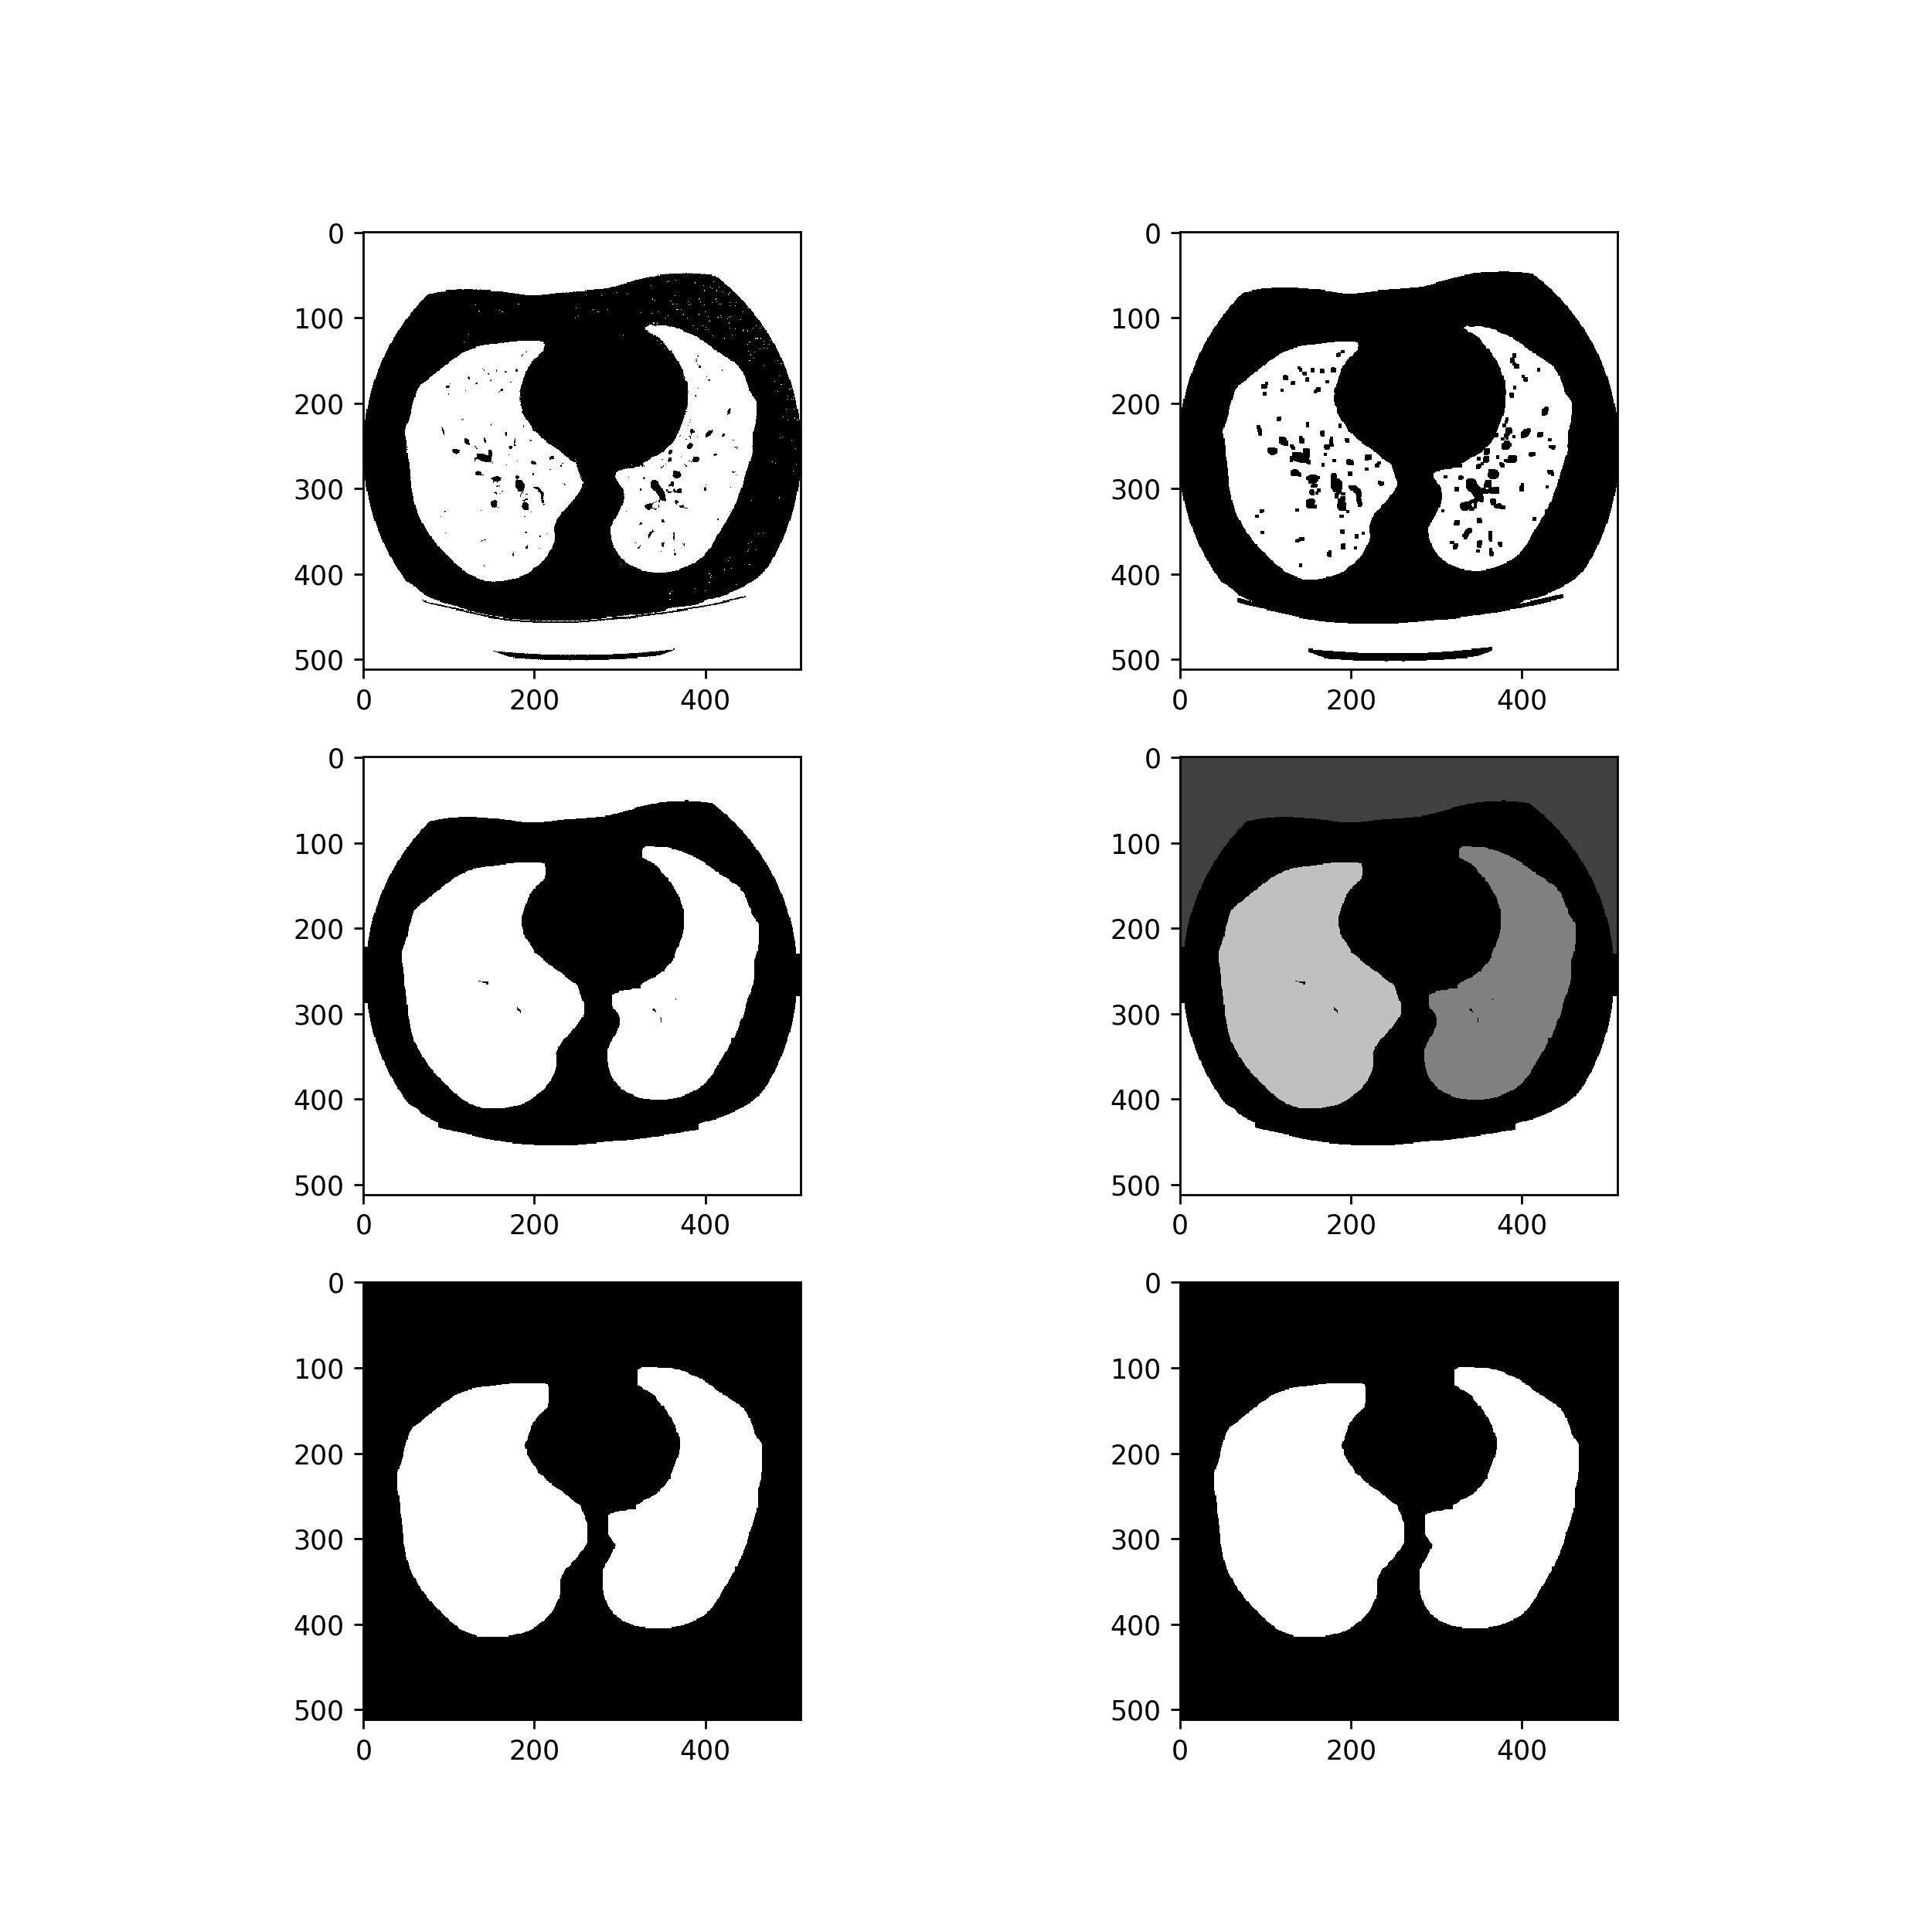

In [10]:
from skimage import measure

for img_file in file_list:
    print(img_file)
    # I ran into an error when using Kmean on np.float16, so I'm using np.float64 here
    imgs_to_process = np.load(img_file).astype(np.float64) 
    print ("on image", img_file)
    for i in range(len(imgs_to_process)):
        img = imgs_to_process[i]
        #Standardize the pixel values
        mean = np.mean(img)
        std = np.std(img)
        img = img-mean
        img = img/std
        
        # Find the average pixel value near the lungs
        # to renormalize washed out images
        middle = img[100:400,100:400] 
        mean = np.mean(middle)  
        max = np.max(img)
        min = np.min(img)
        # To improve threshold finding, I'm moving the 
        # underflow and overflow on the pixel spectrum
        #img[img==max]=mean
        #img[img==min]=mean
        #
        # Using Kmeans to separate foreground (radio-opaque tissue)
        # and background (radio transparent tissue ie lungs)
        # Doing this only on the center of the image to avoid 
        # the non-tissue parts of the image as much as possible
        #
        valid_values = np.reshape(middle,[np.prod(middle.shape),1])
        kmeans = KMeans(n_clusters=2).fit(valid_values)
        centers = sorted(kmeans.cluster_centers_.flatten())
        threshold = np.mean(centers)
        print(threshold)
        thresh_img = np.where(img<threshold,1.0,0.0)  # threshold the image
        
        
        eroded = morphology.erosion(thresh_img,np.ones([4,4]))
        dilation = morphology.dilation(eroded,np.ones([10,10]))
        labels = measure.label(dilation)
        
        fig,ax = plt.subplots(3,2,figsize=[10,10])
        ax[0,0].imshow(thresh_img,cmap='gray') #imagem pos separacao da threshold
        ax[0,1].imshow(eroded, cmap='gray') # threshold erodido
        ax[1,0].imshow(dilation, cmap='gray') # ... e depois dilatado
        ax[1,1].imshow(labels,cmap='gray') # marcacao de labels

        regions = measure.regionprops(labels)
        good_labels = []
        for prop in regions:
            B = prop.bbox
            if B[2]-B[0]<475 and B[3]-B[1]<475 and B[0]>40 and B[2]<472:
                good_labels.append(prop.label)

        mask = np.ndarray([512,512],dtype=np.int8)
        mask[:] = 0
        #
        #  The mask here is the mask for the lungs--not the nodes
        #  After just the lungs are left, we do another large dilation
        #  in order to fill in and out the lung mask 
        #
        for N in good_labels:
            mask = mask + np.where(labels==N,1,0)
        mask = morphology.dilation(mask,np.ones([10,10])) # one last dilation
          

        ax[2,0].imshow(mask,cmap='gray') # mascara
        ax[2,1].imshow(mask,cmap='gray') # mascara
        
        plt.show()
        
        imgs_to_process[i] = mask
        break
    
        
    np.save(img_file.replace("images","lungmask"),imgs_to_process)
    break

working on file  outs/lungmask_23.npy


C:\Users\lucas\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


<IPython.core.display.Javascript object>


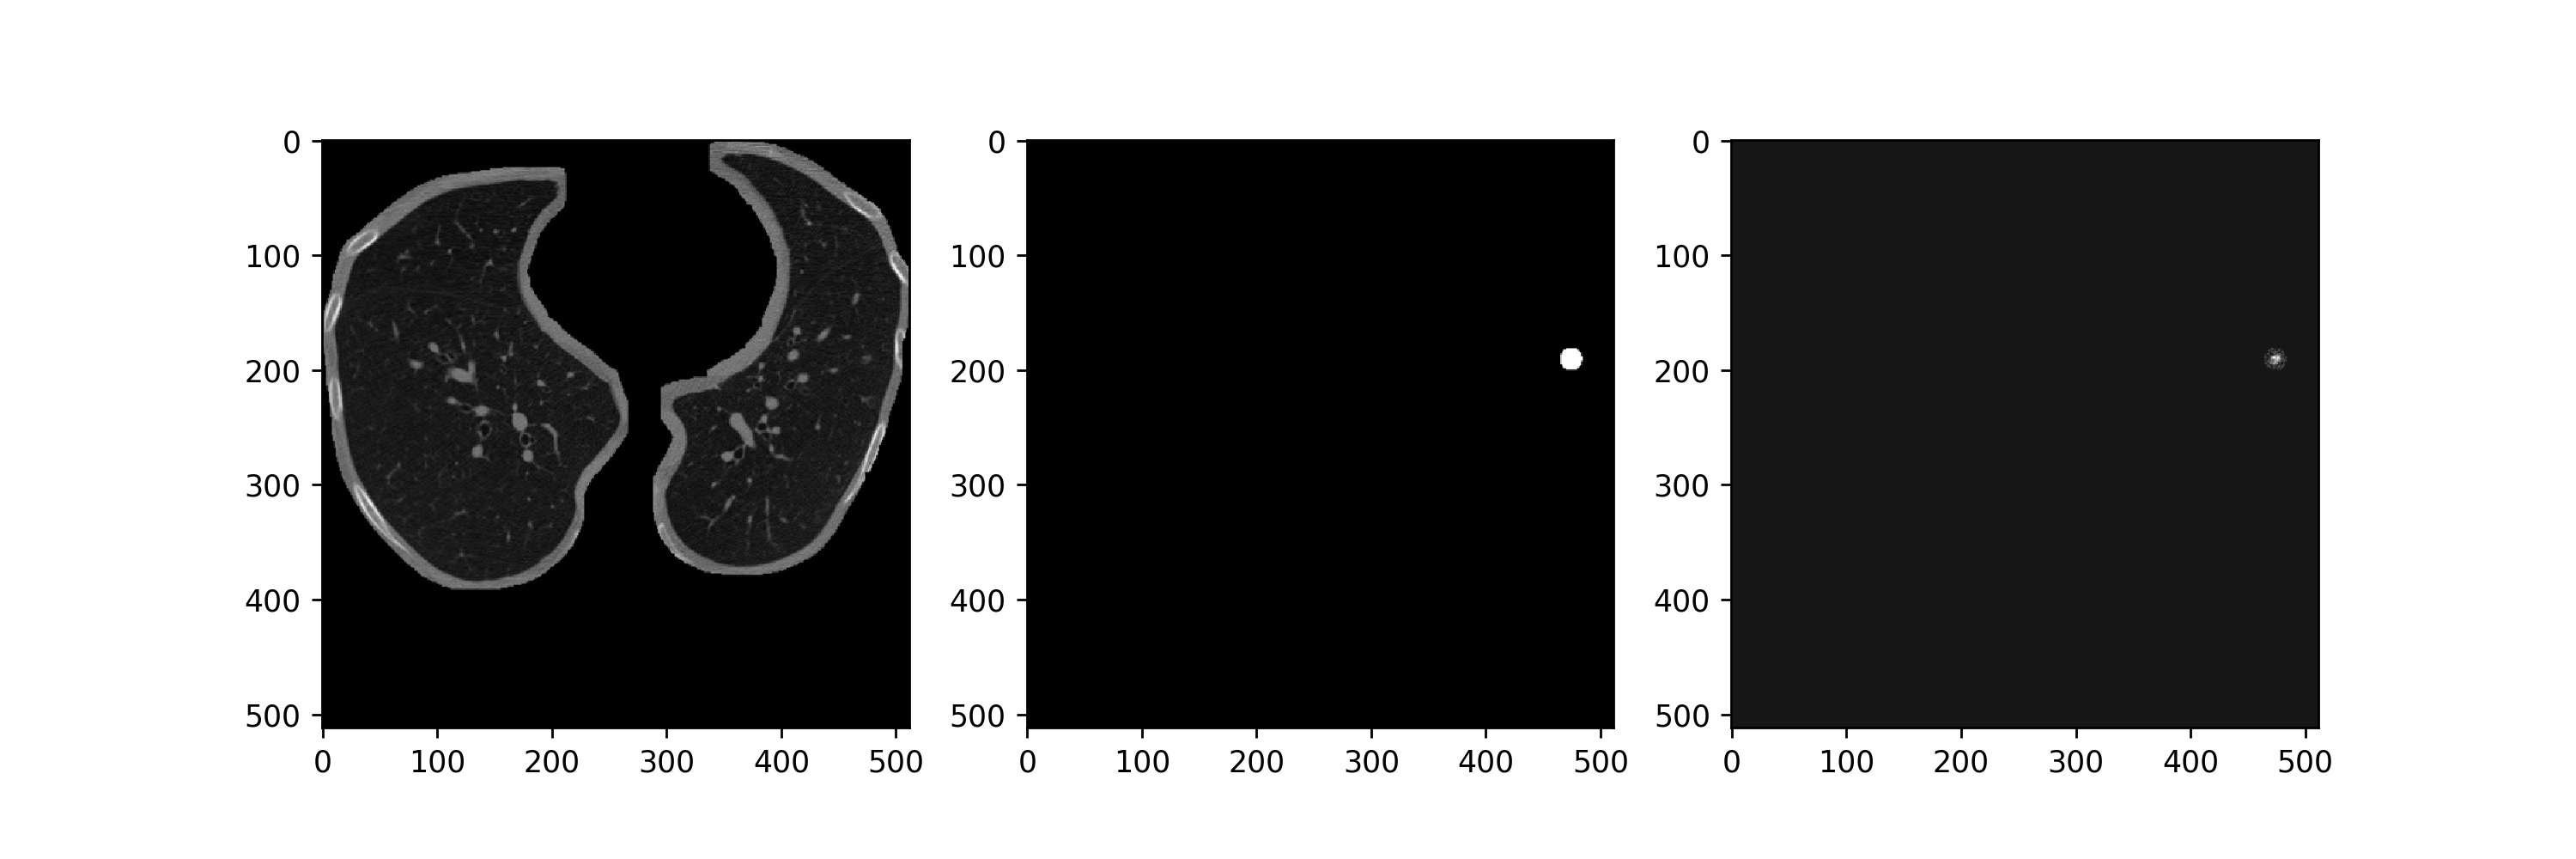

In [13]:
from skimage.transform import resize

file_list=glob(output_path+"lungmask_23.npy")
out_images = []      #final set of images
out_nodemasks = []   #final set of nodemasks
for fname in file_list:
    print("working on file ", fname)
    imgs_to_process = np.load(fname.replace("lungmask","images"))
    masks = np.load(fname)
    node_masks = np.load(fname.replace("lungmask","masks"))
    for i in range(len(imgs_to_process)):
        mask = masks[i]
        node_mask = node_masks[i]
        img = imgs_to_process[i]
        new_size = [512,512]   # we're scaling back up to the original size of the image
        img = mask*img         # apply lung mask

        #
        # renormalizing the masked image (in the mask region)
        #
        new_mean = np.mean(img[mask>0])  
        new_std = np.std(img[mask>0])
        #
        #  Pulling the background color up to the lower end
        #  of the pixel range for the lungs
        #
        old_min = np.min(img)       # background color
        img[img==old_min] = new_mean-1.2*new_std   # resetting backgound color        
        img = img - new_mean
        img = img / new_std
        #make image bounding box  (min row, min col, max row, max col)
        labels = measure.label(mask)
        regions = measure.regionprops(labels)        
        
        #
        # Finding the global min and max row over all regions
        #
        min_row = 512
        max_row = 0
        min_col = 512
        max_col = 0
        for prop in regions:
            B = prop.bbox
            #print(B)
            if min_row > B[0]:
                min_row = B[0]
            if min_col > B[1]:
                min_col = B[1]
            if max_row < B[2]:
                max_row = B[2]
            if max_col < B[3]:
                max_col = B[3]
        width = max_col - min_col
        height = max_row - min_row
        
        if width > height:
            max_row = min_row + width
        else:
            max_col = min_col + height
        
        # 
        # cropping the image down to the bounding box for all regions
        # (there's probably an skimage command that can do this in one line)
        # 
        img = img[min_row:max_row,min_col:max_col]
        mask =  mask[min_row:max_row,min_col:max_col]
        if max_row-min_row <5 or max_col-min_col<5:  # skipping all images with no god regions
            pass
        else:
            # moving range to -1 to 1 to accomodate the resize function
            mean = np.mean(img)
            img = img - mean
            min = np.min(img)
            max = np.max(img)
            img = img/(max-min)
            new_img = resize(img,[512,512])
            new_node_mask = resize(node_mask[min_row:max_row,min_col:max_col],[512,512])
            out_images.append(new_img)
            out_nodemasks.append(new_node_mask)        

            fig,ax = plt.subplots(1,3,figsize=[12,4])
            ax[0].imshow(new_img,cmap='gray')        
            ax[1].imshow(new_node_mask,cmap='gray')
            ax[2].imshow(new_img * new_node_mask,cmap='gray')
            
            plt.show()
            
            break

num_images = len(out_images)
#
#  Writing out images and masks as 1 channel arrays for input into network
#
final_images = np.ndarray([num_images,1,512,512],dtype=np.float32)
final_masks = np.ndarray([num_images,1,512,512],dtype=np.float32)
for i in range(num_images):
    final_images[i,0] = out_images[i]
    final_masks[i,0] = out_nodemasks[i]

rand_i = np.random.choice(range(num_images),size=num_images,replace=False)
test_i = int(0.2*num_images)
np.save(output_path+"trainImages.npy",final_images[rand_i[test_i:]])
np.save(output_path+"trainMasks.npy",final_masks[rand_i[test_i:]])
np.save(output_path+"testImages.npy",final_images[rand_i[:test_i]])
np.save(output_path+"testMasks.npy",final_masks[rand_i[:test_i]])

